In [1]:
from pathlib import Path
from scipy import ndimage


import pandas as pd
import glob, os, shutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import seaborn as sns
from shapely.geometry import Point, Polygon
from scipy.ndimage import gaussian_filter1d
import fnmatch

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',150)

## defined functions

In [2]:
#return 4 points of the corner of the tube
def set_corner_of_tube():
    p_cutoff=0.95
    tubeleftup=df[df.columns[39:42]]
    tubeleftup_likelihood=tubeleftup.iloc[:,2]
    over_p_cutoff_tubeleftup =tubeleftup.loc[tubeleftup_likelihood> p_cutoff]
    tubeleftup_x=over_p_cutoff_tubeleftup.iloc[:,0].mean()
    tubeleftup_y=over_p_cutoff_tubeleftup.iloc[:,1].mean()
    tubeleftdown=df[df.columns[42:45]]
    tubeleftdown_likelihood=tubeleftdown.iloc[:,2]
    over_p_cutoff_tubeleftdown =tubeleftdown.loc[tubeleftdown_likelihood> p_cutoff]
    tubeleftdown_x=over_p_cutoff_tubeleftdown.iloc[:,0].mean()
    tubeleftdown_y=over_p_cutoff_tubeleftdown.iloc[:,1].mean()
    tuberightup=df[df.columns[84:87]]
    tuberightup_likelihood=tuberightup.iloc[:,2]
    over_p_cutoff_tuberightup =tuberightup.loc[tuberightup_likelihood> p_cutoff]
    tuberightup_x=over_p_cutoff_tuberightup.iloc[:,0].mean()
    tuberightup_y=over_p_cutoff_tuberightup.iloc[:,1].mean()
    tuberightdown=df[df.columns[87:90]]
    tuberightdown_likelihood=tuberightdown.iloc[:,2]
    over_p_cutoff_tuberightdown =tuberightdown.loc[tuberightdown_likelihood> p_cutoff]
    tuberightdown_x=over_p_cutoff_tuberightdown.iloc[:,0].mean()
    tuberightdown_y=over_p_cutoff_tuberightdown.iloc[:,1].mean()
    return tubeleftdown_x,tubeleftdown_y,tuberightdown_x,tuberightdown_y,tubeleftup_x,tubeleftup_y,tuberightup_x,tuberightup_y

#this function returns if they are in the tube.
def whetherin(left, right):
    coords = [(tubeleftup_x,tubeleftup_y), 
          (tuberightup_x,tuberightup_y), 
          (tuberightdown_x,tuberightdown_y), 
          (tubeleftdown_x,tubeleftdown_y)]
    polygon = Polygon(coords)
    whetherinleft=[]
    whetherinright=[]
    for i in range(len(left.index)):
        point=Point(left.iloc[i,0],left.iloc[i,1])
        whetherinleft.append(polygon.contains(point))
    left['whetherin']=whetherinleft 
    for i in range(len(right.index)): 
        point=Point(right.iloc[i,0],right.iloc[i,1])
        whetherinright.append(polygon.contains(point))
    right['whetherin']=whetherinright

    
#this function replace the point with likelihood lower than p_cutoff and has out of the region with NAN
def filterpcutoff(left, right, p_cutoff):
    p_cutoff = p_cutoff
    for i in range(len(left.index)):
        if  left.iloc[i,2] <= p_cutoff or left.iloc[i,3]==False:
            left.loc[i]=np.nan
    for i in range(len(right.index)):
        if  right.iloc[i,2] <= p_cutoff or right.iloc[i,3]==False:
            right.loc[i]=np.nan

def trace_filtered():
    bodycenter_x_left=left.iloc[:,0].interpolate(method='linear')
    bodycenter_x_right=right.iloc[:,0].interpolate(method='linear')

    bodycenter_x_left_filtered=pd.Series(gaussian_filter1d(bodycenter_x_left,sigma =6),name="leftxfiltered")
    bodycenter_x_right_filtered=pd.Series(gaussian_filter1d(bodycenter_x_right,sigma = 6),name='rightxfiltered')
    return bodycenter_x_left,bodycenter_x_right,bodycenter_x_left_filtered,bodycenter_x_right_filtered

#this function returns 2 dataframe (left and right), with 5 columns
#first column is after the replacement of zero
#second column is 0,1,-1
#3,4,5, columns represent 'push', 'resist', 'retreat', respectively
def velocity_filtered_with_annotation(threshold):
    
    #get derivative
    bodycenter_x_left_diff=np.diff(bodycenter_x_left_filtered)
    bodycenter_x_right_diff=np.diff(bodycenter_x_right_filtered)

    #set the 1darray into series
    bodycenter_x_left_diff=pd.Series(bodycenter_x_left_diff)
    bodycenter_x_right_diff=pd.Series(bodycenter_x_right_diff)

    #replace the value below specific threshould to zero
    #here we define the threshold
    bodycenter_x_left_diff=np.where(bodycenter_x_left_diff.between(-threshold,threshold),0,bodycenter_x_left_diff)
    bodycenter_x_right_diff=np.where(bodycenter_x_right_diff.between(-threshold,threshold),0,bodycenter_x_right_diff)
    #set the 1darray into series
    bodycenter_x_left_diff=pd.Series(bodycenter_x_left_diff)
    bodycenter_x_right_diff=pd.Series(bodycenter_x_right_diff)
    #set the series to dataframe...
    bodycenter_x_left_diff=bodycenter_x_left_diff.to_frame()
    #create new column, 
    #state contains {'0':resist,'-1':retreat,'1':push}
    # push, resist, retreat are boolean columns
    bodycenter_x_left_diff[['state','push','resist','retreat',
                            'realpush','ineffpush','approach','realresist','stop']]=np.nan
                            #[1,2,3,4,
                            #5,6,7,8,9]
    bodycenter_x_right_diff=bodycenter_x_right_diff.to_frame()
    bodycenter_x_right_diff[['state','push','resist','retreat',
                             'realpush','ineffpush','approach','realresist','stop']]=np.nan
    
    #replace the values in the dataframe right
    for i in range(len(bodycenter_x_right_diff)):
        if bodycenter_x_right_diff.iloc[i,0]<0:
    #for the right side mouse, velocity smaller than 0 is regarded as push
            bodycenter_x_right_diff.iloc[i,1]=1
            bodycenter_x_right_diff.iloc[i,2]=1
            bodycenter_x_right_diff.iloc[i,3]=0   
            bodycenter_x_right_diff.iloc[i,4]=0   

        if bodycenter_x_right_diff.iloc[i,0]==0:
            bodycenter_x_right_diff.iloc[i,1]=0
            bodycenter_x_right_diff.iloc[i,2]=0
            bodycenter_x_right_diff.iloc[i,3]=1   
            bodycenter_x_right_diff.iloc[i,4]=0  

        if bodycenter_x_right_diff.iloc[i,0]>0:
            bodycenter_x_right_diff.iloc[i,1]=-1
            bodycenter_x_right_diff.iloc[i,2]=0
            bodycenter_x_right_diff.iloc[i,3]=0   
            bodycenter_x_right_diff.iloc[i,4]=1  

    #replace the values in the dataframe left
    for i in range(len(bodycenter_x_left_diff)):
        if bodycenter_x_left_diff.iloc[i,0]<0:
            bodycenter_x_left_diff.iloc[i,1]=-1
            bodycenter_x_left_diff.iloc[i,2]=0
            bodycenter_x_left_diff.iloc[i,3]=0   
            bodycenter_x_left_diff.iloc[i,4]=1          

        if bodycenter_x_left_diff.iloc[i,0]==0:
            bodycenter_x_left_diff.iloc[i,1]=0
            bodycenter_x_left_diff.iloc[i,2]=0
            bodycenter_x_left_diff.iloc[i,3]=1  
            bodycenter_x_left_diff.iloc[i,4]=0 

        if bodycenter_x_left_diff.iloc[i,0]>0:
            bodycenter_x_left_diff.iloc[i,1]=1      
            bodycenter_x_left_diff.iloc[i,2]=1
            bodycenter_x_left_diff.iloc[i,3]=0   
            bodycenter_x_left_diff.iloc[i,4]=0  

     #      
    for i in range(len(bodycenter_x_left_diff)): 
        #distinguish left realpush 'diff.iloc[i,5]'
        if  bodycenter_x_left_diff.iloc[i,1]==1 and bodycenter_x_right_diff.iloc[i,1]==-1:
            bodycenter_x_left_diff.iloc[i,5]=1
            bodycenter_x_left_diff.iloc[i,6]=0
            bodycenter_x_left_diff.iloc[i,7]=0
            bodycenter_x_left_diff.iloc[i,8]=0
            bodycenter_x_left_diff.iloc[i,9]=0
            
            bodycenter_x_right_diff.iloc[i,5]=0
            bodycenter_x_right_diff.iloc[i,6]=0
            bodycenter_x_right_diff.iloc[i,7]=0
            bodycenter_x_right_diff.iloc[i,8]=0
            bodycenter_x_right_diff.iloc[i,9]=0
            
        #distinguish right realpush 'diff.iloc[i,5]'
        elif  bodycenter_x_left_diff.iloc[i,1]==-1 and bodycenter_x_right_diff.iloc[i,1]==1:
            bodycenter_x_left_diff.iloc[i,5]=0
            bodycenter_x_left_diff.iloc[i,6]=0
            bodycenter_x_left_diff.iloc[i,7]=0
            bodycenter_x_left_diff.iloc[i,8]=0
            bodycenter_x_left_diff.iloc[i,9]=0
            
            bodycenter_x_right_diff.iloc[i,5]=1
            bodycenter_x_right_diff.iloc[i,6]=0
            bodycenter_x_right_diff.iloc[i,7]=0
            bodycenter_x_right_diff.iloc[i,8]=0
            bodycenter_x_right_diff.iloc[i,9]=0
            
            
        #distinguish approach 'diff.iloc[i,7]'
        elif  bodycenter_x_left_diff.iloc[i,1]==1 and bodycenter_x_right_diff.iloc[i,1]==1:
            bodycenter_x_left_diff.iloc[i,5]=0
            bodycenter_x_left_diff.iloc[i,6]=0
            bodycenter_x_left_diff.iloc[i,7]=1
            bodycenter_x_left_diff.iloc[i,8]=0
            bodycenter_x_left_diff.iloc[i,9]=0  
            
            bodycenter_x_right_diff.iloc[i,5]=0
            bodycenter_x_right_diff.iloc[i,6]=0
            bodycenter_x_right_diff.iloc[i,7]=1
            bodycenter_x_right_diff.iloc[i,8]=0
            bodycenter_x_right_diff.iloc[i,9]=0
            
        #distinguish left ineffpush 'diff.iloc[i,6]', as well as right realresist 'diff.iloc[i,8]'
        elif  bodycenter_x_left_diff.iloc[i,1]==1 and bodycenter_x_right_diff.iloc[i,1]==0:
            bodycenter_x_left_diff.iloc[i,5]=0
            bodycenter_x_left_diff.iloc[i,6]=1
            bodycenter_x_left_diff.iloc[i,7]=0
            bodycenter_x_left_diff.iloc[i,8]=0
            bodycenter_x_left_diff.iloc[i,9]=0
            
            bodycenter_x_right_diff.iloc[i,5]=0
            bodycenter_x_right_diff.iloc[i,6]=0
            bodycenter_x_right_diff.iloc[i,7]=0
            bodycenter_x_right_diff.iloc[i,8]=1
            bodycenter_x_right_diff.iloc[i,9]=0
            
        #distinguish right ineffpush 'diff.iloc[i,6]', as well as left realresist 'diff.iloc[i,8]'
        elif  bodycenter_x_left_diff.iloc[i,1]==0 and bodycenter_x_right_diff.iloc[i,1]==1:
            bodycenter_x_left_diff.iloc[i,5]=0
            bodycenter_x_left_diff.iloc[i,6]=0
            bodycenter_x_left_diff.iloc[i,7]=0
            bodycenter_x_left_diff.iloc[i,8]=1
            bodycenter_x_left_diff.iloc[i,9]=0
            
            bodycenter_x_right_diff.iloc[i,5]=0
            bodycenter_x_right_diff.iloc[i,6]=1
            bodycenter_x_right_diff.iloc[i,7]=0
            bodycenter_x_right_diff.iloc[i,8]=0
            bodycenter_x_right_diff.iloc[i,9]=0                       
            
            
         #distinguish right stop 'diff.iloc[i,9]','
        elif  bodycenter_x_left_diff.iloc[i,1]==0 and bodycenter_x_right_diff.iloc[i,1]==0:
            bodycenter_x_left_diff.iloc[i,5]=0
            bodycenter_x_left_diff.iloc[i,6]=0
            bodycenter_x_left_diff.iloc[i,7]=0
            bodycenter_x_left_diff.iloc[i,8]=0
            bodycenter_x_left_diff.iloc[i,9]=1
            
            bodycenter_x_right_diff.iloc[i,5]=0
            bodycenter_x_right_diff.iloc[i,6]=0
            bodycenter_x_right_diff.iloc[i,7]=0
            bodycenter_x_right_diff.iloc[i,8]=0
            bodycenter_x_right_diff.iloc[i,9]=1                      
        
        else:
            bodycenter_x_left_diff.iloc[i,5]=0
            bodycenter_x_left_diff.iloc[i,6]=0
            bodycenter_x_left_diff.iloc[i,7]=0
            bodycenter_x_left_diff.iloc[i,8]=0
            bodycenter_x_left_diff.iloc[i,9]=0
            
            bodycenter_x_right_diff.iloc[i,5]=0
            bodycenter_x_right_diff.iloc[i,6]=0
            bodycenter_x_right_diff.iloc[i,7]=0
            bodycenter_x_right_diff.iloc[i,8]=0
            bodycenter_x_right_diff.iloc[i,9]=0                      
             
        
    return bodycenter_x_left_diff, bodycenter_x_right_diff


def plot_event_duration_filtered(data):
    fig,ax1=plt.subplots(figsize=(27,7))
    for i in event_true['onset']:
        ax1.axvline(x=i,color='g')
    for i in event_true['end']:
        ax1.axvline(x=i,color='b')
    ax2=ax1.twinx()
    ax2.plot(data,'c-')
    minx=min(left.index)
    maxx=max(left.index)
    ax1.set_xticks(np.arange(minx,maxx,50))
    ax1.set_xticklabels(np.arange((minx * 0.04),maxx * 0.04,2))
    ax1.tick_params(axis='x',labelsize=10,labelrotation=-60)
    #plt.show()
    
    
    
def get_push_and_retreat_event(duration):
    #right realpush
    realpush_right_diff=bodycenter_x_right_diff['realpush'].diff()
    realpush_right_onset=np.where(realpush_right_diff>0)
    realpush_right_end=np.where(realpush_right_diff<0)
    realpush_right_onset=pd.Series(np.array(realpush_right_onset)[0])
    realpush_right_end=pd.Series(np.array(realpush_right_end)[0])

    if realpush_right_onset[0]>realpush_right_end[0]:
        realpush_right_event=pd.concat([realpush_right_onset,
                   realpush_right_end[1:].reset_index(drop=True)],
                  axis=1)
        realpush_right_event['event_duration']=realpush_right_event[1]-realpush_right_event[0]
        realpush_right_event['event_true']=np.where(realpush_right_event['event_duration']>duration,True,False)
        realpush_right_event=realpush_right_event.rename(columns={0:'onset',1:'end'})
        realpush_right_event_true=realpush_right_event[realpush_right_event['event_true']]
    else:
        realpush_right_event=pd.concat([realpush_right_onset,realpush_right_end],axis=1)
        realpush_right_event['event_duration']=realpush_right_event[1]-realpush_right_event[0]
        realpush_right_event['event_true']=np.where(realpush_right_event['event_duration']>duration,True,False)
        realpush_right_event=realpush_right_event.rename(columns={0:'onset',1:'end'})
        realpush_right_event_true=realpush_right_event[realpush_right_event['event_true']]

    #right retreat
    retreat_right_diff=bodycenter_x_right_diff['retreat'].diff()
    retreat_right_onset=np.where(retreat_right_diff>0)
    retreat_right_end=np.where(retreat_right_diff<0)
    retreat_right_onset=pd.Series(np.array(retreat_right_onset)[0])
    retreat_right_end=pd.Series(np.array(retreat_right_end)[0])

    if retreat_right_onset[0]>retreat_right_end[0]:
        retreat_right_event=pd.concat([retreat_right_onset,
                   retreat_right_end[1:].reset_index(drop=True)],
                  axis=1)
        retreat_right_event['event_duration']=retreat_right_event[1]-retreat_right_event[0]
        retreat_right_event['event_true']=np.where(retreat_right_event['event_duration']>duration,True,False)
        retreat_right_event=retreat_right_event.rename(columns={0:'onset',1:'end'})
        retreat_right_event_true=retreat_right_event[retreat_right_event['event_true']]
    else:
        retreat_right_event=pd.concat([retreat_right_onset,retreat_right_end],axis=1)
        retreat_right_event['event_duration']=retreat_right_event[1]-retreat_right_event[0]
        retreat_right_event['event_true']=np.where(retreat_right_event['event_duration']>duration,True,False)
        retreat_right_event=retreat_right_event.rename(columns={0:'onset',1:'end'})
        retreat_right_event_true=retreat_right_event[retreat_right_event['event_true']]

    #left realpush
    realpush_left_diff=bodycenter_x_left_diff['realpush'].diff()
    realpush_left_onset=np.where(realpush_left_diff>0)
    realpush_left_end=np.where(realpush_left_diff<0)
    realpush_left_onset=pd.Series(np.array(realpush_left_onset)[0])
    realpush_left_end=pd.Series(np.array(realpush_left_end)[0])

    if realpush_left_onset[0]>realpush_left_end[0]:
        realpush_left_event=pd.concat([realpush_left_onset,
                   realpush_left_end[1:].reset_index(drop=True)],
                  axis=1)
        realpush_left_event['event_duration']=realpush_left_event[1]-realpush_left_event[0]
        realpush_left_event['event_true']=np.where(realpush_left_event['event_duration']>duration,True,False)
        realpush_left_event=realpush_left_event.rename(columns={0:'onset',1:'end'})
        realpush_left_event_true=realpush_left_event[realpush_left_event['event_true']]
    else:
        realpush_left_event=pd.concat([realpush_left_onset,realpush_left_end],axis=1)
        realpush_left_event['event_duration']=realpush_left_event[1]-realpush_left_event[0]
        realpush_left_event['event_true']=np.where(realpush_left_event['event_duration']>duration,True,False)
        realpush_left_event=realpush_left_event.rename(columns={0:'onset',1:'end'})
        realpush_left_event_true=realpush_left_event[realpush_left_event['event_true']]


    #left retreat
    retreat_left_diff=bodycenter_x_left_diff['retreat'].diff()
    retreat_left_onset=np.where(retreat_left_diff>0)
    retreat_left_end=np.where(retreat_left_diff<0)
    retreat_left_onset=pd.Series(np.array(retreat_left_onset)[0])
    retreat_left_end=pd.Series(np.array(retreat_left_end)[0])

    if retreat_left_onset[0]>retreat_left_end[0]:
        retreat_left_event=pd.concat([retreat_left_onset,
                   retreat_left_end[1:].reset_index(drop=True)],
                  axis=1)
        retreat_left_event['event_duration']=retreat_left_event[1]-retreat_left_event[0]
        retreat_left_event['event_true']=np.where(retreat_left_event['event_duration']>duration,True,False)
        retreat_left_event=retreat_left_event.rename(columns={0:'onset',1:'end'})
        retreat_left_event_true=retreat_left_event[retreat_left_event['event_true']]
    else:
        retreat_left_event=pd.concat([retreat_left_onset,retreat_left_end],axis=1)
        retreat_left_event['event_duration']=retreat_left_event[1]-retreat_left_event[0]
        retreat_left_event['event_true']=np.where(retreat_left_event['event_duration']>duration,True,False)
        retreat_left_event=retreat_left_event.rename(columns={0:'onset',1:'end'})
        retreat_left_event_true=retreat_left_event[retreat_left_event['event_true']]

    retreat_right_event_true=retreat_right_event_true.reset_index()
    realpush_right_event_true=realpush_right_event_true.reset_index()
    retreat_left_event_true=retreat_left_event_true.reset_index()
    realpush_left_event_true=realpush_left_event_true.reset_index()
    
    return retreat_right_event_true, realpush_right_event_true, retreat_left_event_true, realpush_left_event_true



def plot_event_axvspan():
    fig, ax2=plt.subplots(figsize=(27,7))
    l,=ax2.plot(bodycenter_x_left_filtered,linewidth=5,label='leftmouse')
    r,=ax2.plot(bodycenter_x_right_filtered,linewidth=5,label='rightmouse')
    for i in range(len(retreat_left_event_true['onset'])):
        ax2.axvspan(retreat_left_event_true['onset'][i],retreat_left_event_true['end'][i],ymax=0.5,color='blue', alpha=0.4)
    for i in range(len(realpush_left_event_true['onset'])):
        ax2.axvspan(realpush_left_event_true['onset'][i],realpush_left_event_true['end'][i],ymax=0.5,color='green', alpha=0.4)

    for i in range(len(retreat_right_event_true['onset'])):
        ax2.axvspan(retreat_right_event_true['onset'][i],retreat_right_event_true['end'][i],ymin=0.5,color='blue', alpha=0.4)
    for i in range(len(realpush_right_event_true['onset'])):
        ax2.axvspan(realpush_right_event_true['onset'][i],realpush_right_event_true['end'][i],ymin=0.5,color='green', alpha=0.4)
    minx=min(left.index)
    maxx=max(left.index)
    ax2.set_xticks(np.arange(minx,maxx,50))
    ax2.set_xticklabels(np.arange((minx * 0.04),maxx * 0.04,2))
    ax2.tick_params(axis='x',labelsize=10,labelrotation=-60)
    # #ax2.set_xlim([36*25,45*25])

    plt.xlabel('time(s)')
    plt.ylabel('X coordinate')



    legend_elements = [mpatches.Patch(color='blue', alpha=0.4, lw=4, label='retreat'),
                      mpatches.Patch(color='green', alpha=0.4, lw=4, label='realpush'),]

    # ax2.legend(handles=legend_elements, loc='lower center')

    from matplotlib.legend import Legend
    leg = ax2.legend(handles=[r,l],loc='center right')
    ax2.add_artist(leg);
    ax2.legend(handles=legend_elements, loc='lower center')
    ax2.set_title('{}_{}_2mice_eventplot.png'.format(file[:23],left.columns[1][2]))
    
    return fig, ax2

## session definitions 

In [37]:
# hand-pick the led-onset
session_on=[
    950,
    1250,
    2450,
    450,
    350,
    825,
    950,
    3950,
    525,
    1275,
    225,
    625,
    #1325,
    550,
    1825,
    675,
    800,
    3025,
    4373, # the previous value is 4125, however it is changed due to lack of recording
    525,
    325,
    600,
    350,
    350,
    600,
    450,
    350,
    1250,
    1075,
    225,
    1025,
    350,
    225,
    1400,
    350,
    825,
    975,
    475,
    450,
    325,
    425,
    850,
 ]

In [38]:
# hand-pick the led-onset
session_off=[
    1750,
    1825,
    5450,
    950,
    1025,
    1150,
    1475,
    4850,
    1025,
    2825,
    850,
    875,
    #1575,
    1725,
    4750,
    1100,
    1100,
    3750,
    5575,
    2700,
    2875,
    2225,
    3650,
    3525,
    1125,
    2775,
    2000,
    2300,
    2250,
    2225,
    1525,
    2250,
    600,
    2400,
    675,
    3950,
    1650,
    1625,
    2500,
    2725,
    1125,
    2000,
 ]

In [21]:
#when it's day 200814
session_on=session_on[20:41]
session_off=session_off[20:41]
file_path = r'C:\data\tube_test\dlc_data_new_yichen\200814'
file_to_open = [f for f in os.listdir(file_path) if f.endswith('.h5')]

fp_path =r'C:\data\tube_test\fp_data\200814'
fp_files = [f for f in os.listdir(fp_path) if f.endswith('dff.csv')]

In [39]:
#when it's day 200813
session_on=session_on[0:20]
session_off=session_off[0:20]
#file_path = r'\\svfas5.epfl.ch\Sandi-Lab\yichen\jun\tubetestrefinement\data\tube_test_data\dlc_data_new_yichen\200813'
file_path = r'C:\data\tube_test\dlc_data_new_yichen\200813'

file_to_open = [f for f in os.listdir(file_path) if f.endswith('.h5')]

#fp_path =r'\\svfas5.epfl.ch\Sandi-Lab\yichen\jun\tubetestrefinement\data\tube_test_data\fp_data\200813'
fp_path =r'C:\data\tube_test\fp_data\200813'

fp_files = [f for f in os.listdir(fp_path) if f.endswith('dff.csv')]

# proces with baseline correction

### 200814

In [22]:
allmus_right_retreat_0814=np.empty([21, 10*1000])
allmus_left_retreat_0814=np.empty([21, 10*1000])
allmus_right_push_0814=np.empty([21, 10*1000])
allmus_left_push_0814=np.empty([21, 10*1000])

for i in range(len(file_to_open)):
    file=file_to_open[i]
    print(file)

    fp_data= os.path.join(fp_path, fp_files[i])
    #read .h5 file of DLC data
    df=pd.read_hdf(os.path.join(file_path,file_to_open[i]))
    df_np=df.to_numpy()
    #trim DLC data to the LED signals...
    df_np=df_np[np.arange((session_on[i]+1),(session_off[i]+1+1)),:]
    df_np=df_np[1:,:]
    df_np=df_np.astype(str)
    df_np=np.frompyfunc(lambda x: x.replace(',',''),1,1)(df_np).astype(float)
    df_loc=pd.DataFrame(data=df_np, columns=df.columns)


    #after trim
    tubeleftdown_x,tubeleftdown_y,tuberightdown_x,tuberightdown_y,tubeleftup_x,tubeleftup_y,tuberightup_x,tuberightup_y=set_corner_of_tube()
    #start to analyze the data of back
    left, right=df_loc[df_loc.columns[18:21]],df_loc[df_loc.columns[63:66]]
    whetherin(left, right)
    filterpcutoff(left,right, 0.95)
    bodycenter_x_left,bodycenter_x_right,bodycenter_x_left_filtered,bodycenter_x_right_filtered=trace_filtered()
    bodycenter_x_left_diff,bodycenter_x_right_diff=velocity_filtered_with_annotation(0.15)
    #set the threshold of duration of event
    retreat_right_event_true, realpush_right_event_true, retreat_left_event_true, realpush_left_event_true=get_push_and_retreat_event(18)    

    #read related FP file
    df_fp=pd.read_csv(fp_data)
    #align FP signal the same index with DLC,
    #in this case, the length of DLC and FP would be same, which is at the frequency of 25 (1 index value is equal to 0.04s)
    #but the overall lenth/frequency of FP is still 40 times longer than DLC
    df_fp_index=df_fp.index.values
    index_new=df_fp_index/40
    df_fp=df_fp.set_index(index_new)
    #name new series 'dFF1' representign left mouse
    dFF1= df_fp['dFF_mice1']
    dFF2= df_fp['dFF_mice2']
    #get zscore of each series
    dFF1_zscore=(dFF1-dFF1.mean())/dFF1.std()
    dFF2_zscore=(dFF2-dFF2.mean())/dFF2.std()

    #set an empty ndarray, with 6000 columns representing 6seconds with 1000Hz frequency
    #row numbers represent the event numbers 
    #retreat
    mus_right_retreat=np.empty([len(retreat_right_event_true['onset']), 10*1000])
    mus_left_retreat=np.empty([len(retreat_left_event_true['onset']), 10*1000])

    #push
    mus_right_push=np.empty([len(realpush_right_event_true['onset']), 10*1000])
    mus_left_push=np.empty([len(realpush_left_event_true['onset']), 10*1000])


   # fig,ax=plt.subplots(2,2,figsize=(16,12))

    #put the event into the ndarray
    for j in range(len(retreat_right_event_true['onset'])):
        #calculate the baseline value of dFF of each event
        #I define baseline as +-0.2 second around the initiation of event
        #because I wanted to see in each event, how the value changes relative to the value at onset timepoint
        baselinevalue=np.mean(dFF2_zscore.iloc[np.arange(retreat_right_event_true['onset'][j]-75,
                                                          retreat_right_event_true['onset'][j]-25,
                                                          0.025)])
        mus_right_retreat[j,:]=dFF2_zscore.iloc[np.arange(retreat_right_event_true['onset'][j]-75,
                                                          retreat_right_event_true['onset'][j]+175,
                                                          0.025)].subtract(baselinevalue)
    #    sns.lineplot(ax=ax[0,1],data=mus_right_retreat[j],color='b')

    for k in range(len(retreat_left_event_true['onset'])):
        baselinevalue=np.mean(dFF1_zscore.iloc[np.arange(retreat_left_event_true['onset'][k]-75,
                                                          retreat_left_event_true['onset'][k]-25,
                                                          0.025)])
        mus_left_retreat[k,:]=dFF1_zscore.iloc[np.arange(retreat_left_event_true['onset'][k]-75,
                                                         retreat_left_event_true['onset'][k]+175,
                                                         0.025)].subtract(baselinevalue)
    #    sns.lineplot(ax=ax[0,1],data=mus_left_retreat[k],color='y')  


    for l in range(len(realpush_right_event_true['onset'])):
        baselinevalue=np.mean(dFF2_zscore.iloc[np.arange(realpush_right_event_true['onset'][l]-75,
                                                          realpush_right_event_true['onset'][l]-25,
                                                          0.025)])
        mus_right_push[l,:]=dFF2_zscore.iloc[np.arange(realpush_right_event_true['onset'][l]-75,
                                                          realpush_right_event_true['onset'][l]+175,
                                                          0.025)].subtract(baselinevalue)
   #     sns.lineplot(ax=ax[1,1],data=mus_right_push[l],color='b')

    for m in range(len(realpush_left_event_true['onset'])):
        baselinevalue=np.mean(dFF1_zscore.iloc[np.arange(realpush_left_event_true['onset'][m]-75,
                                                          realpush_left_event_true['onset'][m]-25,
                                                          0.025)])
        mus_left_push[m,:]=dFF1_zscore.iloc[np.arange(realpush_left_event_true['onset'][m]-75,
                                                         realpush_left_event_true['onset'][m]+175,
                                                         0.025)].subtract(baselinevalue)
    #    sns.lineplot(ax=ax[1,1],data=mus_left_push[m],color='y')  

    #plot mean of all retreat events of both side mice on Aut 14 2020
   # sns.lineplot(ax=ax[0,0],data=np.nanmean(mus_right_retreat,axis=0),label='rightmouse')
   # sns.lineplot(ax=ax[0,0],data=np.nanmean(mus_left_retreat,axis=0),label='leftmouse')
   # ax[0,0].set_title('{}_2mice_fpsignal_perievent_retreat.png'.format(file[:23]))
   # ax[0,0].legend()  

    #plot mean of all push events of both side mice on Aut 14 2020
    #sns.lineplot(ax=ax[1,0],data=np.nanmean(mus_right_push,axis=0),label='rightmouse')
    #sns.lineplot(ax=ax[1,0],data=np.nanmean(mus_left_push,axis=0),label='leftmouse')
    #ax[1,0].set_title('{}_2mice_fpsignal_perievent_push.png'.format(file[:23]))
    #ax[1,0].legend()   
    #fig.tight_layout()
    
    allmus_right_retreat_0814[i,:]=np.nanmean(mus_right_retreat,axis=0)
    allmus_left_retreat_0814[i,:]=np.nanmean(mus_left_retreat,axis=0) 
    allmus_right_push_0814[i,:]=np.nanmean(mus_right_push,axis=0)
    allmus_left_push_0814[i,:]=np.nanmean(mus_left_push,axis=0)

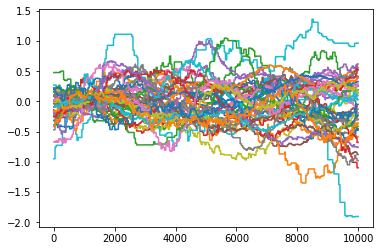

In [23]:
plt.plot(np.transpose(np.concatenate((allmus_right_retreat_0814,allmus_left_retreat_0814),axis=0)))

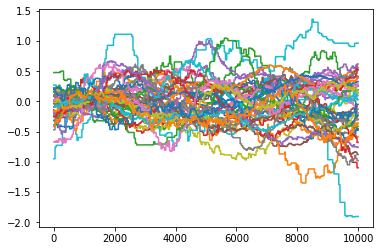

In [24]:
plt.plot(np.transpose(np.concatenate((allmus_right_retreat_0814,allmus_left_retreat_0814),axis=0)))

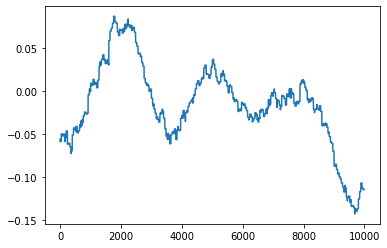

In [25]:
allmus_retreat_0814=np.concatenate((allmus_right_retreat_0814,allmus_left_retreat_0814),axis=0)
#plot mean of all retreat events of each right side mouse on Aut 14 2020
plt.plot(np.nanmean(allmus_retreat_0814,axis=0))

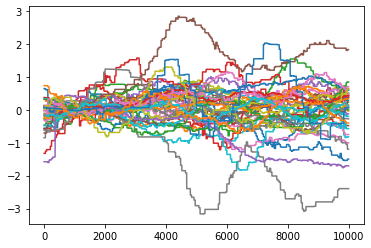

In [26]:
plt.plot(np.transpose(np.concatenate((allmus_right_push_0814,allmus_left_push_0814),axis=0)))

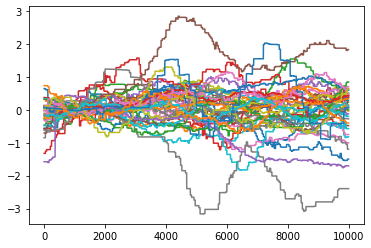

In [27]:
plt.plot(np.transpose(np.concatenate((allmus_right_push_0814,allmus_left_push_0814),axis=0)))

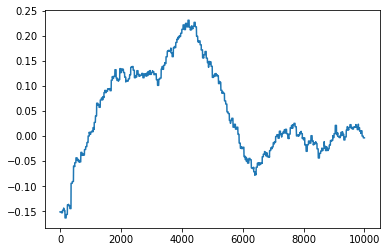

In [28]:
allmus_push_0814=np.concatenate((allmus_right_push_0814,allmus_left_push_0814),axis=0)
#plot mean of all push events of each right side mouse on Aut 14 2020
plt.plot(np.nanmean(allmus_push_0814,axis=0))

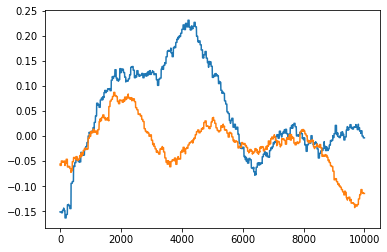

In [29]:
plt.plot(np.nanmean(allmus_push_0814,axis=0))
plt.plot(np.nanmean(allmus_retreat_0814,axis=0))

In [33]:
timevec=np.arange(-3, 7, 1/1000)

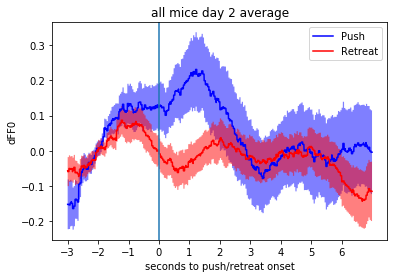

In [36]:
mu1 = np.nanmean(allmus_push_0814,0)
sigma1 = np.nanstd(allmus_push_0814,0)/np.sqrt(len(allmus_push_0814))
mu2 = np.nanmean(allmus_retreat_0814,0)
sigma2 = np.nanstd(allmus_retreat_0814,0)/np.sqrt(len(allmus_retreat_0814))

plt.fill_between(timevec, mu1+sigma1, mu1-sigma1, facecolor='blue', alpha=0.5)
plt.fill_between(timevec, mu2+sigma2, mu2-sigma2, facecolor='red', alpha=0.5)
plt.plot(timevec,np.nanmean(allmus_push_0814,axis=0),'b',timevec,np.nanmean(allmus_retreat_0814,axis=0),'r')
plt.axvline(x=0)
plt.xticks(np.arange(-3, 7))
plt.xlabel('seconds to push/retreat onset')
plt.ylabel('dFF0')
plt.title('all mice day 2 average')
plt.legend(['Push', 'Retreat'])
plt.savefig('all_mice_day_2.jpg', dpi=300)

### 200813

In [40]:
allmus_right_retreat_0813=np.empty([20, 10*1000])
allmus_left_retreat_0813=np.empty([20, 10*1000])
allmus_right_push_0813=np.empty([20, 10*1000])
allmus_left_push_0813=np.empty([20, 10*1000])

for i in range(len(file_to_open)):
    file=file_to_open[i]
    print(file)

    fp_data= os.path.join(fp_path, fp_files[i])
    #read .h5 file of DLC data
    df=pd.read_hdf(os.path.join(file_path,file_to_open[i]))
    df_np=df.to_numpy()
    #trim DLC data to the LED signals...
    df_np=df_np[np.arange((session_on[i]+1),(session_off[i]+1+1)),:]
    df_np=df_np[1:,:]
    df_np=df_np.astype(str)
    df_np=np.frompyfunc(lambda x: x.replace(',',''),1,1)(df_np).astype(float)
    df_loc=pd.DataFrame(data=df_np, columns=df.columns)


    #after trim
    tubeleftdown_x,tubeleftdown_y,tuberightdown_x,tuberightdown_y,tubeleftup_x,tubeleftup_y,tuberightup_x,tuberightup_y=set_corner_of_tube()
    #start to analyze the data of back
    left, right=df_loc[df_loc.columns[18:21]],df_loc[df_loc.columns[63:66]]
    whetherin(left, right)
    filterpcutoff(left,right, 0.95)
    bodycenter_x_left,bodycenter_x_right,bodycenter_x_left_filtered,bodycenter_x_right_filtered=trace_filtered()
    bodycenter_x_left_diff,bodycenter_x_right_diff=velocity_filtered_with_annotation(0.15)
    #set the threshold of duration of event
    retreat_right_event_true, realpush_right_event_true, retreat_left_event_true, realpush_left_event_true=get_push_and_retreat_event(18)    

    #read related FP file
    df_fp=pd.read_csv(fp_data)
    #align FP signal the same index with DLC,
    #in this case, the length of DLC and FP would be same, which is at the frequency of 25 (1 index value is equal to 0.04s)
    #but the overall lenth/frequency of FP is still 40 times longer than DLC
    df_fp_index=df_fp.index.values
    index_new=df_fp_index/40
    df_fp=df_fp.set_index(index_new)
    #name new series 'dFF1' representign left mouse
    dFF1= df_fp['dFF_mice1']
    dFF2= df_fp['dFF_mice2']
    #get zscore of each series
    dFF1_zscore=(dFF1-dFF1.mean())/dFF1.std()
    dFF2_zscore=(dFF2-dFF2.mean())/dFF2.std()

    #set an empty ndarray, with 6000 columns representing 6seconds with 1000Hz frequency
    #row numbers represent the event numbers 
    #retreat
    mus_right_retreat=np.empty([len(retreat_right_event_true['onset']), 10*1000])
    mus_left_retreat=np.empty([len(retreat_left_event_true['onset']), 10*1000])

    #push
    mus_right_push=np.empty([len(realpush_right_event_true['onset']), 10*1000])
    mus_left_push=np.empty([len(realpush_left_event_true['onset']), 10*1000])


    #fig,ax=plt.subplots(2,2,figsize=(16,12))

    #put the event into the ndarray
    for j in range(len(retreat_right_event_true['onset'])):
        #calculate the baseline value of dFF of each event
        #I define baseline as +-0.2 second around the initiation of event
        #because I wanted to see in each event, how the value changes relative to the value at onset timepoint
        baselinevalue=np.mean(dFF2_zscore.iloc[np.arange(retreat_right_event_true['onset'][j]-75,
                                                          retreat_right_event_true['onset'][j]-25,
                                                          0.025)])
        mus_right_retreat[j,:]=dFF2_zscore.iloc[np.arange(retreat_right_event_true['onset'][j]-75,
                                                          retreat_right_event_true['onset'][j]+175,
                                                          0.025)].subtract(baselinevalue)
        #sns.lineplot(ax=ax[0,1],data=mus_right_retreat[j],color='b')

    for k in range(len(retreat_left_event_true['onset'])):
        baselinevalue=np.mean(dFF1_zscore.iloc[np.arange(retreat_left_event_true['onset'][k]-75,
                                                          retreat_left_event_true['onset'][k]-25,
                                                          0.025)])
        mus_left_retreat[k,:]=dFF1_zscore.iloc[np.arange(retreat_left_event_true['onset'][k]-75,
                                                         retreat_left_event_true['onset'][k]+175,
                                                         0.025)].subtract(baselinevalue)
        #sns.lineplot(ax=ax[0,1],data=mus_left_retreat[k],color='y')  


    for l in range(len(realpush_right_event_true['onset'])):
        baselinevalue=np.mean(dFF2_zscore.iloc[np.arange(realpush_right_event_true['onset'][l]-75,
                                                          realpush_right_event_true['onset'][l]-25,
                                                          0.025)])
        mus_right_push[l,:]=dFF2_zscore.iloc[np.arange(realpush_right_event_true['onset'][l]-75,
                                                          realpush_right_event_true['onset'][l]+175,
                                                          0.025)].subtract(baselinevalue)
        #sns.lineplot(ax=ax[1,1],data=mus_right_push[l],color='b')

    for m in range(len(realpush_left_event_true['onset'])):
        baselinevalue=np.mean(dFF1_zscore.iloc[np.arange(realpush_left_event_true['onset'][m]-75,
                                                          realpush_left_event_true['onset'][m]-25,
                                                          0.025)])
        mus_left_push[m,:]=dFF1_zscore.iloc[np.arange(realpush_left_event_true['onset'][m]-75,
                                                         realpush_left_event_true['onset'][m]+175,
                                                         0.025)].subtract(baselinevalue)
        #sns.lineplot(ax=ax[1,1],data=mus_left_push[m],color='y')  

    #plot mean of all retreat events of both side mice on Aut 13 2020
    #sns.lineplot(ax=ax[0,0],data=np.nanmean(mus_right_retreat,axis=0),label='rightmouse')
    #sns.lineplot(ax=ax[0,0],data=np.nanmean(mus_left_retreat,axis=0),label='leftmouse')
    #ax[0,0].set_title('{}_2mice_fpsignal_perievent_retreat.png'.format(file[:23]))
    #ax[0,0].legend()  

    #plot mean of all push events of both side mice on Aut 13 2020
    #sns.lineplot(ax=ax[1,0],data=np.nanmean(mus_right_push,axis=0),label='rightmouse')
    #sns.lineplot(ax=ax[1,0],data=np.nanmean(mus_left_push,axis=0),label='leftmouse')
    #ax[1,0].set_title('{}_2mice_fpsignal_perievent_push.png'.format(file[:23]))
    #ax[1,0].legend()    

    #fig.tight_layout()
    
    allmus_right_retreat_0813[i,:]=np.nanmean(mus_right_retreat,axis=0)
    allmus_left_retreat_0813[i,:]=np.nanmean(mus_left_retreat,axis=0)
    allmus_right_push_0813[i,:]=np.nanmean(mus_right_push,axis=0)
    allmus_left_push_0813[i,:]=np.nanmean(mus_left_push,axis=0)

cage30847_trial1_130820_ttDLC_dlcrnetms5_tubeFeb2shuffle2_100000_el.h5
cage30847_trial2_130820_ttDLC_dlcrnetms5_tubeFeb2shuffle2_100000_el.h5
cage30847_trial3_130820_ttDLC_dlcrnetms5_tubeFeb2shuffle2_100000_el.h5
cage30848_trial1_130820_ttDLC_dlcrnetms5_tubeFeb2shuffle2_100000_el.h5
cage30848_trial2_130820_ttDLC_dlcrnetms5_tubeFeb2shuffle2_100000_el.h5
cage30848_trial3_130820_ttDLC_dlcrnetms5_tubeFeb2shuffle2_100000_el.h5
cage30849_trial1_130820_ttDLC_dlcrnetms5_tubeFeb2shuffle2_100000_el.h5
cage30849_trial2_130820_ttDLC_dlcrnetms5_tubeFeb2shuffle2_100000_el.h5
cage30849_trial3_130820_ttDLC_dlcrnetms5_tubeFeb2shuffle2_100000_el.h5
cage30850_trial1_130820_ttDLC_dlcrnetms5_tubeFeb2shuffle2_100000_el.h5
cage30850_trial2_130820_ttDLC_dlcrnetms5_tubeFeb2shuffle2_100000_el.h5
cage30850_trial3_130820_ttDLC_dlcrnetms5_tubeFeb2shuffle2_100000_el.h5
cage30851_trial2_130820_ttDLC_dlcrnetms5_tubeFeb2shuffle2_100000_el.h5
cage30851_trial3_130820_ttDLC_dlcrnetms5_tubeFeb2shuffle2_100000_el.h5
cage30

In [74]:
i

0

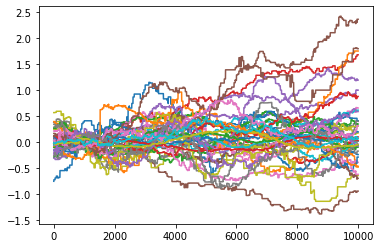

In [41]:
plt.plot(np.transpose(np.concatenate((allmus_right_retreat_0813,allmus_left_retreat_0813),axis=0)))

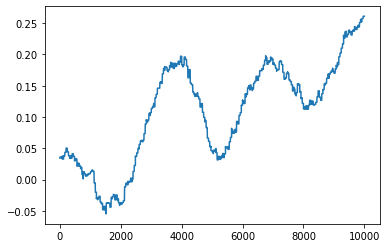

In [42]:
allmus_retreat_0813=np.concatenate((allmus_right_retreat_0813,allmus_left_retreat_0813),axis=0)
#plot mean of all retreat events of each right side mouse on Aut 13 2020
plt.plot(np.nanmean(allmus_retreat_0813,axis=0))

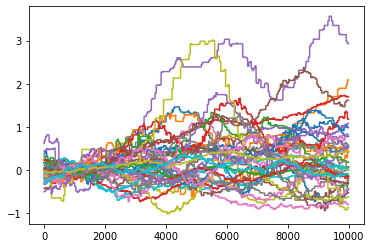

In [43]:
fig,ax=plt.subplots()
ax.plot(np.transpose(np.concatenate((allmus_right_push_0813,allmus_left_push_0813),axis=0)))


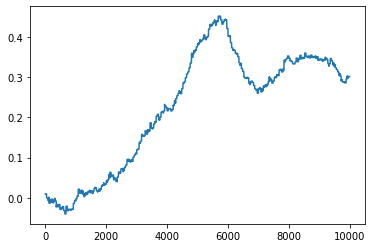

In [44]:
allmus_push_0813=np.concatenate((allmus_right_push_0813,allmus_left_push_0813),axis=0)
#plot mean of all push events of each right side mouse on Aut 13 2020
plt.plot(np.nanmean(allmus_push_0813,axis=0))

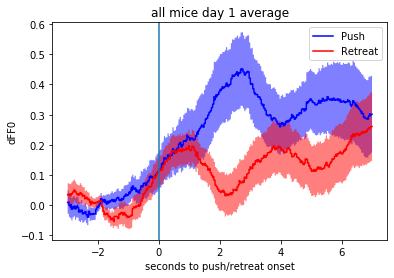

In [47]:
mu3 = np.nanmean(allmus_push_0813,0)
sigma3 = np.nanstd(allmus_push_0813,0)/np.sqrt(len(allmus_push_0813))
mu4 = np.nanmean(allmus_retreat_0813,0)
sigma4 = np.nanstd(allmus_retreat_0813,0)/np.sqrt(len(allmus_retreat_0813))

plt.fill_between(timevec, mu3+sigma3, mu3-sigma3, facecolor='blue', alpha=0.5)
plt.fill_between(timevec, mu4+sigma4, mu4-sigma4, facecolor='red', alpha=0.5)
plt.plot(timevec,np.nanmean(allmus_push_0813,axis=0),'b',timevec,np.nanmean(allmus_retreat_0813,axis=0),'r')
plt.axvline(x=0)
plt.xlabel('seconds to push/retreat onset')
plt.ylabel('dFF0')
plt.title('all mice day 1 average')
plt.legend(['Push', 'Retreat'])
plt.savefig('all_mice_day_1.jpg', dpi=300)

In [51]:
t1=np.arange(0,20,3)
t2=np.arange(1,20,3)
t3=np.arange(2,20,3)

In [53]:
t1

array([ 0,  3,  6,  9, 12, 15, 18])

In [54]:
t2

array([ 1,  4,  7, 10, 13, 16, 19])

In [55]:
t3

array([ 2,  5,  8, 11, 14, 17])

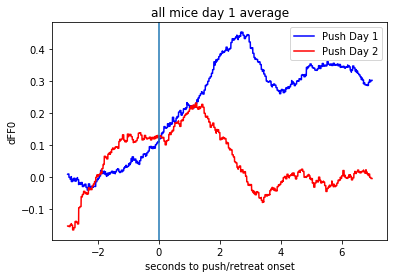

In [49]:
plt.plot(timevec,np.nanmean(allmus_push_0813,axis=0),'b',timevec,np.nanmean(allmus_push_0814,axis=0),'r')
plt.axvline(x=0)
plt.xlabel('seconds to push/retreat onset')
plt.ylabel('dFF0')
plt.title('all mice day 1 average')
plt.legend(['Push Day 1', 'Push Day 2'])
plt.savefig('all_mice_day_1.jpg', dpi=300)

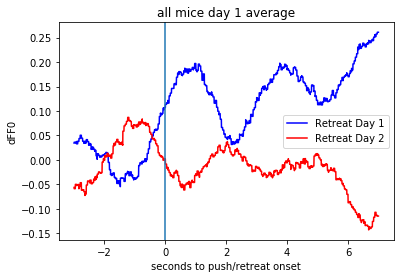

In [50]:
plt.plot(timevec,np.nanmean(allmus_retreat_0813,axis=0),'b',timevec,np.nanmean(allmus_retreat_0814,axis=0),'r')
plt.axvline(x=0)
plt.xlabel('seconds to push/retreat onset')
plt.ylabel('dFF0')
plt.title('all mice day 1 average')
plt.legend(['Retreat Day 1', 'Retreat Day 2'])
plt.savefig('all_mice_day_1.jpg', dpi=300)


In [103]:
t1=[ 0,  3,  6,  9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39]
t2=[ 1,  4,  7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40]
t3=[ 2,  5,  8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38]

array([ 0,  3,  6,  9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39])

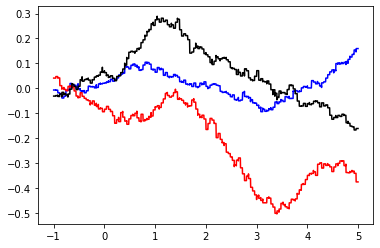

In [118]:
plt.plot(timevec, np.nanmean([allmus_push_0814[i] for i in t1],0),'b', timevec, np.nanmean([allmus_push_0814[i] for i in t2],0),'r', timevec, np.nanmean([allmus_push_0814[i] for i in t3],0),'k')


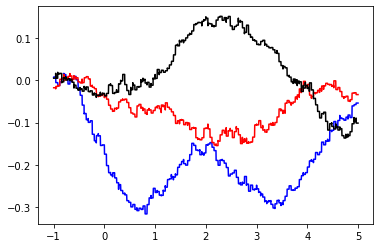

In [121]:
plt.plot(timevec, np.nanmean([allmus_retreat_0814[i] for i in t1],0),'b', timevec, np.nanmean([allmus_retreat_0814[i] for i in t2],0),'r', timevec, np.nanmean([allmus_retreat_0814[i] for i in t3],0),'k')


### all

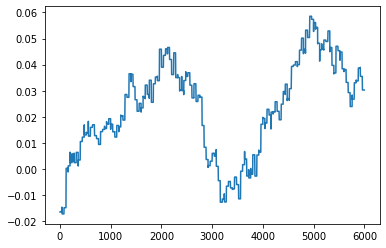

In [141]:
allmus_retreat=np.concatenate((allmus_retreat_0813,allmus_retreat_0814),axis=0)
#plot mean of all retreat events of every mouse
plt.plot(np.nanmean(allmus_retreat,axis=0))

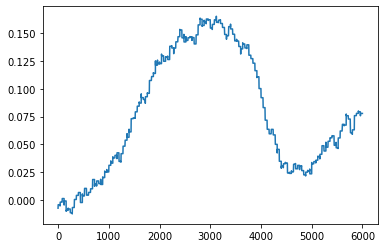

In [140]:
allmus_push=np.concatenate((allmus_push_0813,allmus_push_0814),axis=0)
#plot mean of all push events of every mouse
plt.plot(np.nanmean(allmus_push,axis=0))

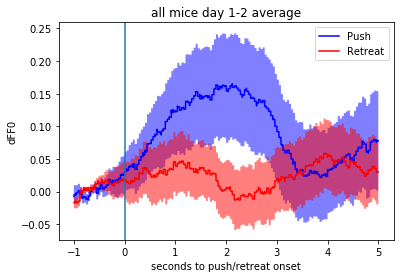

In [142]:
mu5 = np.nanmean(allmus_push,0)
sigma5 = np.nanstd(allmus_push,0)/np.sqrt(len(allmus_push))
mu6 = np.nanmean(allmus_retreat,0)
sigma6 = np.nanstd(allmus_retreat,0)/np.sqrt(len(allmus_retreat))

plt.fill_between(timevec, mu5+sigma5, mu5-sigma5, facecolor='blue', alpha=0.5)
plt.fill_between(timevec, mu6+sigma6, mu6-sigma6, facecolor='red', alpha=0.5)
plt.plot(timevec,np.nanmean(allmus_push,axis=0),'b',timevec,np.nanmean(allmus_retreat,axis=0),'r')
plt.axvline(x=0)
plt.xlabel('seconds to push/retreat onset')
plt.ylabel('dFF0')
plt.title('all mice day 1-2 average')
plt.legend(['Push', 'Retreat'])
plt.savefig('all_mice_day_12.jpg', dpi=300)

### one example...

In [139]:
j=1
baselinevalue=np.mean(dFF2_zscore.iloc[np.arange(retreat_right_event_true['onset'][j]-5,
                                                      retreat_right_event_true['onset'][j]+5,
                                                      0.025)])
baselinevalue

2.0817456341956198

In [140]:
dFF2_zscore.iloc[np.arange(retreat_right_event_true['onset'][j]-25,
                                                      retreat_right_event_true['onset'][j]+125,
                                                      0.025)].subtract(baselinevalue)

12.925    0.197143
12.925    0.197143
12.925    0.197143
12.925    0.197143
12.925    0.197143
            ...   
16.650   -0.611042
16.650   -0.611042
16.650   -0.611042
16.650   -0.611042
16.650   -0.611042
Name: dFF_mice2, Length: 6000, dtype: float64

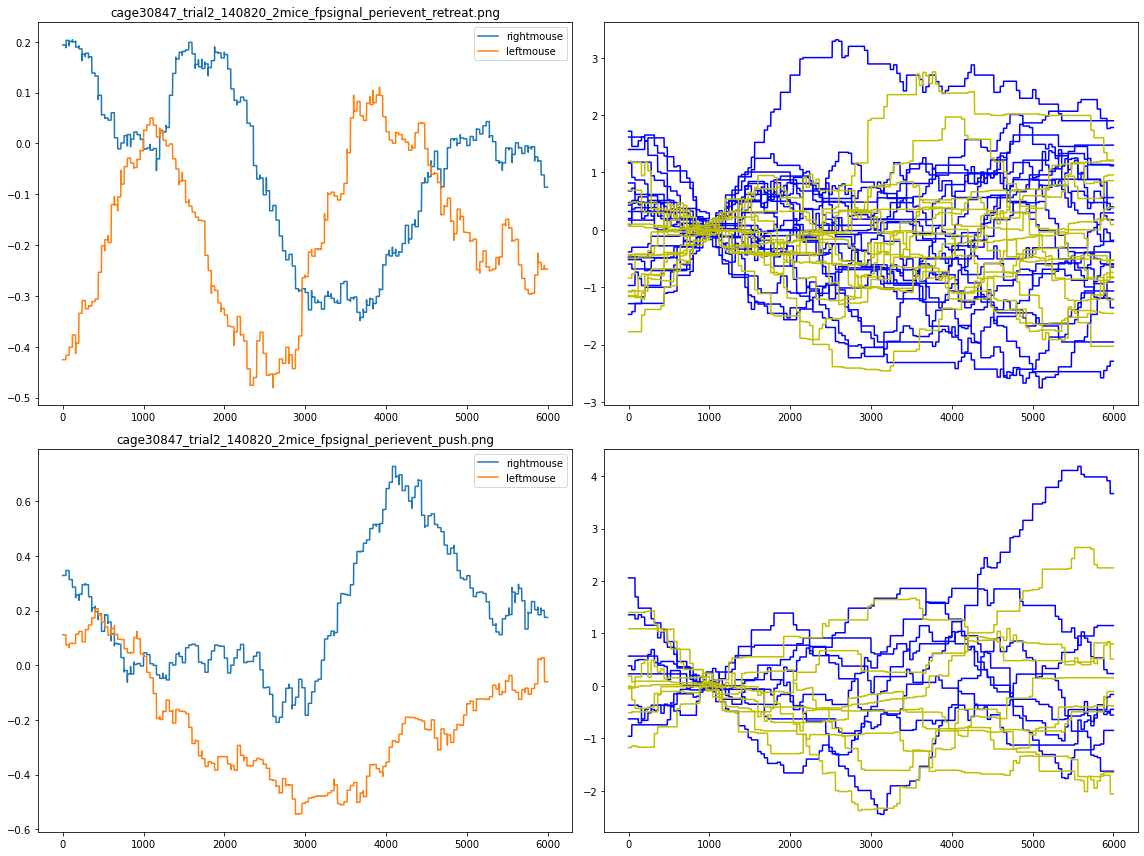

In [142]:
allmus_right_retreat_0814=np.empty([21, 6*1000])
allmus_left_retreat_0814=np.empty([21, 6*1000])
allmus_right_push_0814=np.empty([21, 6*1000])
allmus_left_push_0814=np.empty([21, 6*1000])

i=1    
file=file_to_open[i]

fp_data= os.path.join(fp_path, fp_files[i])
#read .h5 file of DLC data
df=pd.read_hdf(os.path.join(file_path,file_to_open[i]))
df_np=df.to_numpy()
#trim DLC data to the LED signals...
df_np=df_np[np.arange((session_on[i]+1),(session_off[i]+1+1)),:]
df_np=df_np[1:,:]
df_np=df_np.astype(str)
df_np=np.frompyfunc(lambda x: x.replace(',',''),1,1)(df_np).astype(float)
df_loc=pd.DataFrame(data=df_np, columns=df.columns)


#after trim
tubeleftdown_x,tubeleftdown_y,tuberightdown_x,tuberightdown_y,tubeleftup_x,tubeleftup_y,tuberightup_x,tuberightup_y=set_corner_of_tube()
#start to analyze the data of back
left, right=df_loc[df_loc.columns[18:21]],df_loc[df_loc.columns[63:66]]
whetherin(left, right)
filterpcutoff(left,right, 0.95)
bodycenter_x_left,bodycenter_x_right,bodycenter_x_left_filtered,bodycenter_x_right_filtered=trace_filtered()
bodycenter_x_left_diff,bodycenter_x_right_diff=velocity_filtered_with_annotation(0.15)
#set the threshold of duration of event
retreat_right_event_true, realpush_right_event_true, retreat_left_event_true, realpush_left_event_true=get_push_and_retreat_event(18)    

#read related FP file
df_fp=pd.read_csv(fp_data)
#align FP signal the same index with DLC,
#in this case, the length of DLC and FP would be same, which is at the frequency of 25 (1 index value is equal to 0.04s)
#but the overall lenth/frequency of FP is still 40 times longer than DLC
df_fp_index=df_fp.index.values
index_new=df_fp_index/40
df_fp=df_fp.set_index(index_new)
#name new series 'dFF1' representign left mouse
dFF1= df_fp['dFF_mice1']
dFF2= df_fp['dFF_mice2']
#get zscore of each series
dFF1_zscore=(dFF1-dFF1.mean())/dFF1.std()
dFF2_zscore=(dFF2-dFF2.mean())/dFF2.std()

#set an empty ndarray, with 6000 columns representing 6seconds with 1000Hz frequency
#row numbers represent the event numbers 
#retreat
mus_right_retreat=np.empty([len(retreat_right_event_true['onset']), 6*1000])
mus_left_retreat=np.empty([len(retreat_left_event_true['onset']), 6*1000])

#push
mus_right_push=np.empty([len(realpush_right_event_true['onset']), 6*1000])
mus_left_push=np.empty([len(realpush_left_event_true['onset']), 6*1000])


fig,ax=plt.subplots(2,2,figsize=(16,12))

#put the event into the ndarray
for j in range(len(retreat_right_event_true['onset'])):
    #calculate the baseline value of dFF of each event
    #I define baseline as +-0.2 second around the initiation of event
    #because I wanted to see in each event, how the value changes relative to the value at onset timepoint
    baselinevalue=np.mean(dFF2_zscore.iloc[np.arange(retreat_right_event_true['onset'][j]-5,
                                                      retreat_right_event_true['onset'][j]+5,
                                                      0.025)])
    mus_right_retreat[j,:]=dFF2_zscore.iloc[np.arange(retreat_right_event_true['onset'][j]-25,
                                                      retreat_right_event_true['onset'][j]+125,
                                                      0.025)].subtract(baselinevalue)
    sns.lineplot(ax=ax[0,1],data=mus_right_retreat[j],color='b')

for k in range(len(retreat_left_event_true['onset'])):
    baselinevalue=np.mean(dFF1_zscore.iloc[np.arange(retreat_left_event_true['onset'][k]-5,
                                                      retreat_left_event_true['onset'][k]+5,
                                                      0.025)])
    mus_left_retreat[k,:]=dFF1_zscore.iloc[np.arange(retreat_left_event_true['onset'][k]-25,
                                                     retreat_left_event_true['onset'][k]+125,
                                                     0.025)].subtract(baselinevalue)
    sns.lineplot(ax=ax[0,1],data=mus_left_retreat[k],color='y')  


for l in range(len(realpush_right_event_true['onset'])):
    baselinevalue=np.mean(dFF2_zscore.iloc[np.arange(realpush_right_event_true['onset'][l]-5,
                                                      realpush_right_event_true['onset'][l]+5,
                                                      0.025)])
    mus_right_push[l,:]=dFF2_zscore.iloc[np.arange(realpush_right_event_true['onset'][l]-25,
                                                      realpush_right_event_true['onset'][l]+125,
                                                      0.025)].subtract(baselinevalue)
    sns.lineplot(ax=ax[1,1],data=mus_right_push[l],color='b')

for m in range(len(realpush_left_event_true['onset'])):
    baselinevalue=np.mean(dFF1_zscore.iloc[np.arange(realpush_left_event_true['onset'][m]-5,
                                                      realpush_left_event_true['onset'][m]+5,
                                                      0.025)])
    mus_left_push[m,:]=dFF1_zscore.iloc[np.arange(realpush_left_event_true['onset'][m]-25,
                                                     realpush_left_event_true['onset'][m]+125,
                                                     0.025)].subtract(baselinevalue)
    sns.lineplot(ax=ax[1,1],data=mus_left_push[m],color='y')  

#plot mean of all retreat events of both side mice on Aut 14 2020
sns.lineplot(ax=ax[0,0],data=np.nanmean(mus_right_retreat,axis=0),label='rightmouse')
sns.lineplot(ax=ax[0,0],data=np.nanmean(mus_left_retreat,axis=0),label='leftmouse')
ax[0,0].set_title('{}_2mice_fpsignal_perievent_retreat.png'.format(file[:23]))
ax[0,0].legend()  

#plot mean of all push events of both side mice on Aut 14 2020
sns.lineplot(ax=ax[1,0],data=np.nanmean(mus_right_push,axis=0),label='rightmouse')
sns.lineplot(ax=ax[1,0],data=np.nanmean(mus_left_push,axis=0),label='leftmouse')
ax[1,0].set_title('{}_2mice_fpsignal_perievent_push.png'.format(file[:23]))
ax[1,0].legend()   
fig.tight_layout()

allmus_right_retreat_0814[i,:]=np.nanmean(mus_right_retreat,axis=0)
allmus_left_retreat_0814[i,:]=np.nanmean(mus_left_retreat,axis=0) 
allmus_right_push_0814[i,:]=np.nanmean(mus_right_push,axis=0)
allmus_left_push_0814[i,:]=np.nanmean(mus_left_push,axis=0)